In [68]:
# Load the Google Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
# TODO
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:

import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
nrow = 50
ncol = 50
data_dir = '/content/drive/My Drive/Colab Notebooks/project/test'

data_size = 800
folder = np.array(['Bulbasaur','Charmander','Pikachu','Squirtle'], dtype=str)

# data_size = 500*12
# folder = np.array(['Arcanine','Bulbasaur','Charizard','Charmander','Eevee','Jigglypuff','Lucario','Mew','Mudkip','Pikachu','Squirtle','Umbereon'], dtype=str)

In [142]:
import os
k = 0;
data_shape = (data_size,nrow,ncol)
x = np.zeros(data_shape)
y = np.zeros(data_size)
for i, j in enumerate(folder):
  class_path = os.path.join(data_dir, folder[i])
  for image_name in os.listdir(class_path):
    if(image_name != '.ipynb_checkpoints'):
      image_path = os.path.join(class_path, image_name)
      x[k,:,:] = image.load_img(image_path, target_size=(nrow, ncol), grayscale=True)
      y[k] = i
      k = k + 1

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [0]:
X = x.reshape((data_size,nrow*ncol))

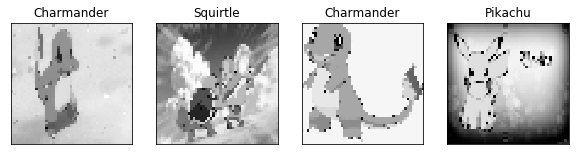

In [154]:
def plt_pic(x):
    h = nrow
    w = ncol
    plt.imshow(x.reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    
I = np.random.permutation(data_size)
plt.figure(figsize=(10,20))
nplt = 4;
for i in range(nplt):    
    ind = I[i]
    plt.subplot(1,nplt,i+1)
    plt_pic(X[ind])
    plt.title(folder[int(y[ind])])

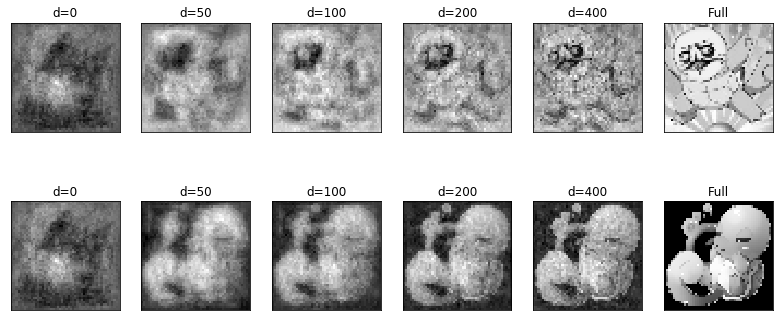

In [157]:
nplt = 2               # number of pics to plot
ds = [0,50,100,200,400]   # number of SVD approximations
use_pca = True         # True=Use sklearn reconstruction, else use SVD

if use_pca:
    # Construct the PCA object for the max number of coefficient
    dmax = np.max(ds)
    pca = PCA(n_components=dmax, svd_solver='randomized', whiten=True)
    
    # Fit and transform the data
    pca.fit(X)
    Z = pca.transform(X)
    

# Fit the PCA components on the entire dataset
pca.fit(X)

# Select random pics
inds = np.random.permutation(data_size)
inds = inds[:nplt]
nd = len(ds)

# Set figure size
plt.figure(figsize=(1.8 * (nd+1), 2.4 * nplt))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

# Loop over figures
iplt = 0
for ind in inds:
    for d in ds:
        plt.subplot(nplt,nd+1,iplt+1)
        if use_pca:
            # Zero out coefficients after d.  
            # Note, we need to copy to not overwrite the coefficients
            Zd = np.copy(Z[ind,:])
            Zd[d:] = 0
            Xhati = pca.inverse_transform(Zd)
        else:
            # Reconstruct with SVD
            Xhati = (U[ind,:d]*S[None,:d]).dot(Vtr[:d,:]) + Xmean
            
        plt_pic(Xhati)
        plt.title('d={0:d}'.format(d))
        iplt += 1
    
    # Plot
    plt.subplot(nplt,nd+1,iplt+1)
    plt_pic(X[ind,:])
    plt.title('Full')
    iplt += 1

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

scaler = StandardScaler()
pca = PCA()
svc = SVC(kernel='rbf')
pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', svc)])

In [0]:
ncomp_test = np.arange(3,11)
c = np.array([0,1,2,3,4,5],dtype=float)
c_test = 10**c
g = np.array([-6,-5,-4,-3,-2],dtype=float)
gam_test = 10**g

In [0]:
params = {'pca__n_components': ncomp_test, 'svc__C' : c_test, 'svc__gamma' : gam_test}

In [161]:
estimator = GridSearchCV(pipe, params, cv=5, return_train_score =True, iid=False)
estimator.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'pca__n_components': array([ 3,  4,  5,  6,  7,  8,  9, 10]), 'svc__C': array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]), 'svc__gamma': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [185]:
print('Best test score is',estimator.best_score_)
print('Best parameters are',estimator.best_params_)

Best test score is 0.5549999999999999
Best parameters are {'pca__n_components': 10, 'svc__C': 1000.0, 'svc__gamma': 0.0001}


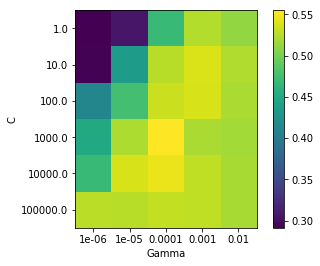

In [191]:
best_parameters = estimator.best_estimator_.get_params()
C_best = best_parameters['pca__n_components'] - 3
test_score = estimator.cv_results_['mean_test_score']
scores = test_score.reshape(len(ncomp_test),len(c_test),len(gam_test))

plt.imshow(scores[C_best, :, :])
plt.xlabel('Gamma')
plt.ylabel('C')
plt.colorbar()

ax = plt.gca()
n0 = len(c_test)
n1 = len(gam_test)
ax.set_xticks(np.arange(0,n1))
ax.set_xticklabels(gam_test)
ax.set_yticks(np.arange(0,n0))
_ = ax.set_yticklabels(c_test)
plt.show()